<a href="https://colab.research.google.com/github/fikrifaizz/Real-Time-Fraud-Detection-System/blob/main/notebooks/03_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    average_precision_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import json

In [21]:
train_df = pd.read_csv('../data/processed/train_set.csv')
val_df = pd.read_csv('../data/processed/val_set.csv')
test_df = pd.read_csv('../data/processed/test_set.csv')

print(f"Train: {len(train_df):,} rows")
print(f"Val:   {len(val_df):,} rows")
print(f"Test:  {len(test_df):,} rows")

Train: 354,324 rows
Val:   118,108 rows
Test:  118,108 rows


In [22]:
drop_cols = ['TransactionID', 'TransactionDT', 'isFraud']
feature_cols = [col for col in train_df.columns if col not in drop_cols]

X_train = train_df[feature_cols]
y_train = train_df['isFraud']

X_val = val_df[feature_cols]
y_val = val_df['isFraud']

X_test = test_df[feature_cols]
y_test = test_df['isFraud']

print(f"Features: {len(feature_cols)}")
print(f"Fraud rate - Train: {y_train.mean()*100:.2f}%")

Features: 443
Fraud rate - Train: 3.38%


In [23]:
print("Training LightGBM...")

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.1f}")

lgb_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    verbose=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lambda x: None]  # Silent mode
)

# Predict
lgb_pred_proba = lgb_model.predict_proba(X_val)[:, 1]
lgb_auc = roc_auc_score(y_val, lgb_pred_proba)
lgb_prauc = average_precision_score(y_val, lgb_pred_proba)

print(f"LightGBM - ROC-AUC: {lgb_auc:.4f}, PR-AUC: {lgb_prauc:.4f}")

Training LightGBM...
Scale pos weight: 28.6
LightGBM - ROC-AUC: 0.9197, PR-AUC: 0.5816


In [24]:
print("Training XGBoost...")

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='auc',
    verbosity=0
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Predict
xgb_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
xgb_auc = roc_auc_score(y_val, xgb_pred_proba)
xgb_prauc = average_precision_score(y_val, xgb_pred_proba)

print(f"XGBoost - ROC-AUC: {xgb_auc:.4f}, PR-AUC: {xgb_prauc:.4f}")

Training XGBoost...
XGBoost - ROC-AUC: 0.9194, PR-AUC: 0.5843


In [25]:
print("Training CatBoost...")

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=7,
    l2_leaf_reg=3,
    subsample=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    verbose=0
)

cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    verbose=False
)

# Predict
cat_pred_proba = cat_model.predict_proba(X_val)[:, 1]
cat_auc = roc_auc_score(y_val, cat_pred_proba)
cat_prauc = average_precision_score(y_val, cat_pred_proba)

print(f"CatBoost - ROC-AUC: {cat_auc:.4f}, PR-AUC: {cat_prauc:.4f}")

Training CatBoost...
CatBoost - ROC-AUC: 0.9207, PR-AUC: 0.5745



MODEL COMPARISON

    Model  ROC-AUC   PR-AUC
 XGBoost 0.919351 0.584347
LightGBM 0.919680 0.581556
CatBoost 0.920699 0.574510


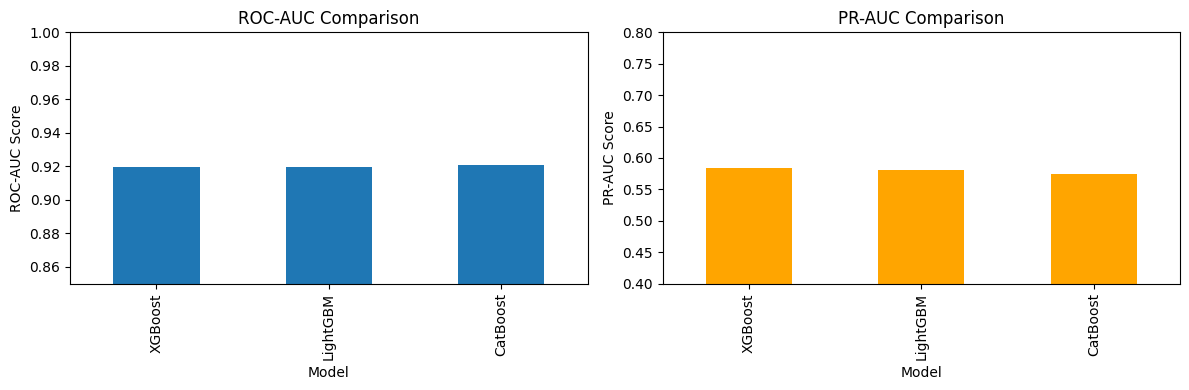

In [26]:
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

results = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'CatBoost'],
    'ROC-AUC': [lgb_auc, xgb_auc, cat_auc],
    'PR-AUC': [lgb_prauc, xgb_prauc, cat_prauc]
})
results = results.sort_values('PR-AUC', ascending=False)
print("\n", results.to_string(index=False))

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

results.plot(x='Model', y='ROC-AUC', kind='bar', ax=ax[0], legend=False)
ax[0].set_title('ROC-AUC Comparison')
ax[0].set_ylabel('ROC-AUC Score')
ax[0].set_ylim(0.85, 1.0)

results.plot(x='Model', y='PR-AUC', kind='bar', ax=ax[1], legend=False, color='orange')
ax[1].set_title('PR-AUC Comparison')
ax[1].set_ylabel('PR-AUC Score')
ax[1].set_ylim(0.4, 0.8)

plt.tight_layout()
plt.show()

In [27]:
print("Creating Ensemble...")

# Weighted average based on PR-AUC performance
weights = {
    'lightgbm': 0.5,
    'xgboost': 0.3,
    'catboost': 0.2
}

ensemble_pred_proba = (
    weights['lightgbm'] * lgb_pred_proba + 
    weights['xgboost'] * xgb_pred_proba + 
    weights['catboost'] * cat_pred_proba
)

ensemble_auc = roc_auc_score(y_val, ensemble_pred_proba)
ensemble_prauc = average_precision_score(y_val, ensemble_pred_proba)

print(f"Ensemble - ROC-AUC: {ensemble_auc:.4f}, PR-AUC: {ensemble_prauc:.4f}")
print(f"   Weights: {weights}")

Creating Ensemble...
Ensemble - ROC-AUC: 0.9258, PR-AUC: 0.5925
   Weights: {'lightgbm': 0.5, 'xgboost': 0.3, 'catboost': 0.2}


In [28]:
print("Optimizing Threshold...")

# Business costs
FP_COST = 10   # False positive: manual review cost
FN_COST = 200  # False negative: fraud loss

thresholds = np.arange(0.1, 0.9, 0.05)
best_profit = -float('inf')
best_threshold = 0.5

for threshold in thresholds:
    y_pred = (ensemble_pred_proba >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    
    # Calculate profit
    cost = (fp * FP_COST) + (fn * FN_COST)
    saved = tp * FN_COST  # Fraud prevented
    profit = saved - cost
    
    if profit > best_profit:
        best_profit = profit
        best_threshold = threshold

print(f"Best Threshold: {best_threshold:.2f}")
print(f"   Profit: ${best_profit:,.0f}")

# Evaluate at best threshold
y_pred_final = (ensemble_pred_proba >= best_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred_final).ravel()

print(f"\nConfusion Matrix:")
print(f"   True Negatives:  {tn:,}")
print(f"   False Positives: {fp:,}")
print(f"   False Negatives: {fn:,}")
print(f"   True Positives:  {tp:,}")

Optimizing Threshold...
Best Threshold: 0.30
   Profit: $462,830

Confusion Matrix:
   True Negatives:  92,120
   False Positives: 21,377
   False Negatives: 614
   True Positives:  3,997


Feature Importance (Top 20)
            feature  importance
              card1         502
      card_txn_mean         465
                day         456
     TransactionAmt         452
              addr1         435
     card_txn_count         386
card_usage_duration         386
              card2         376
                C13         369
       card_txn_std         367
       card_txn_max         364
       card_txn_min         357
                D15         259
                 C1         249
P_emaildomain_count         241
                D10         240
                 D1         231
      P_emaildomain         207
                 D2         206
              id_20         204


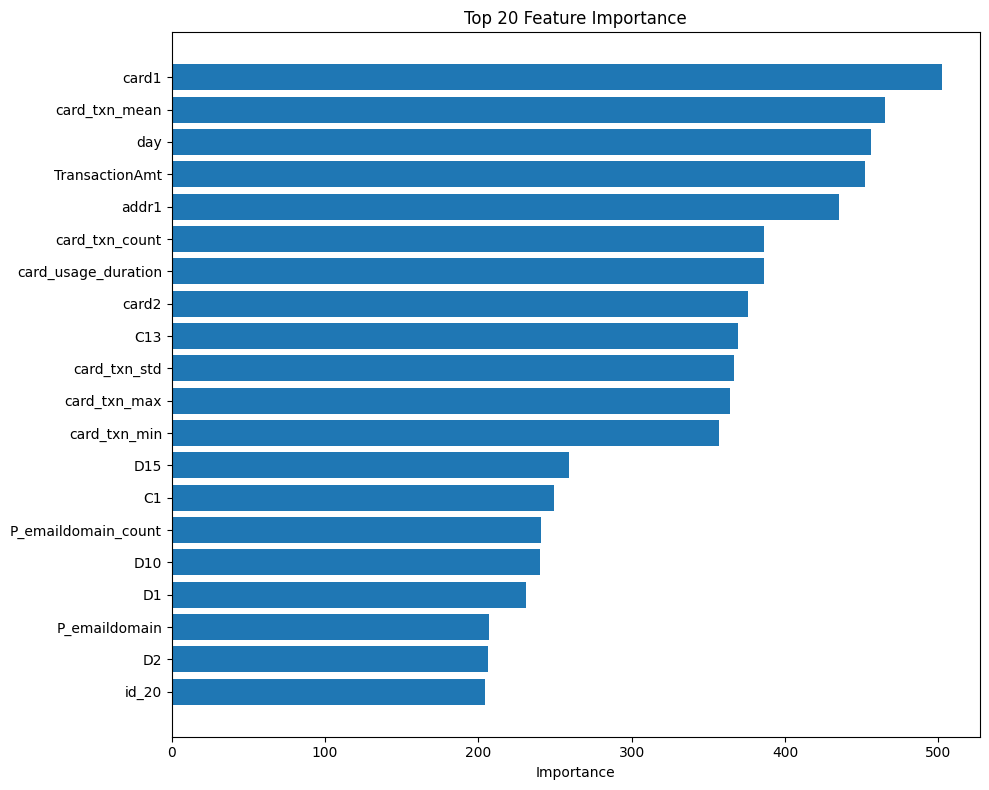

In [29]:
print("Feature Importance (Top 20)")

# Get LightGBM feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

print(importance_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [32]:
os.makedirs("../models", exist_ok=True)

with open('../models/lightgbm_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

with open('../models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

with open('../models/catboost_model.pkl', 'wb') as f:
    pickle.dump(cat_model, f)

ensemble_config = {
    'weights': {k: float(v) for k, v in weights.items()},
    'threshold': float(best_threshold),
    'performance': {
        'roc_auc': float(ensemble_auc),
        'pr_auc': float(ensemble_prauc),
        'profit': int(best_profit),
    }
}

with open('../models/ensemble_config.json', 'w') as f:
    json.dump(ensemble_config, f, indent=2)

In [33]:
print("FINAL TEST SET EVALUATION")

# Ensemble prediction on test set
lgb_test_pred = lgb_model.predict_proba(X_test)[:, 1]
xgb_test_pred = xgb_model.predict_proba(X_test)[:, 1]
cat_test_pred = cat_model.predict_proba(X_test)[:, 1]

ensemble_test_pred = (
    weights['lightgbm'] * lgb_test_pred + 
    weights['xgboost'] * xgb_test_pred + 
    weights['catboost'] * cat_test_pred
)

y_test_pred = (ensemble_test_pred >= best_threshold).astype(int)

# Metrics
test_auc = roc_auc_score(y_test, ensemble_test_pred)
test_prauc = average_precision_score(y_test, ensemble_test_pred)

print(f"\nTest Set Performance:")
print(f"   ROC-AUC: {test_auc:.4f}")
print(f"   PR-AUC:  {test_prauc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Legitimate', 'Fraud']))

FINAL TEST SET EVALUATION

Test Set Performance:
   ROC-AUC: 0.8856
   PR-AUC:  0.4850

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      0.81      0.89    114044
       Fraud       0.13      0.80      0.23      4064

    accuracy                           0.81    118108
   macro avg       0.56      0.81      0.56    118108
weighted avg       0.96      0.81      0.87    118108

